In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

import hmf
from hmf import MassFunction, Transfer   

import emcee
import sys
sys.path.append('../21cm_ETHOS/21cmFAST-ethos-analysis-main/')
import sheth_tormen as st

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15 as P15
from astropy import constants as const
import astropy.units as u

%load_ext line_profiler

In [2]:
#Cosmology

omega_cdm = 0.12
CosmoParams_input = zeus21.Cosmo_Parameters_Input(omegac = omega_cdm)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
parcos = zeus21.Cosmo_Parameters(CosmoParams_input,ClassyCosmo)
corrf = zeus21.Correlations(parcos,ClassyCosmo)

#Astrophysics

eps_star = 0.15
parastro = zeus21.Astro_Parameters(parcos, epsstar=eps_star)




In [3]:
eth_zeus= zeus21.HMF_interpolator(parcos, ClassyCosmo,LCDM=False, h_peak=0.4, k_peak=80)



In [4]:
T21_coeff = zeus21.get_T21_coefficients(parcos, ClassyCosmo, parastro, eth_zeus, zmin=8) 

In [5]:
#21 cm power spectrum

powerspec21 = zeus21.Power_Spectra(parcos, ClassCosmo, corrf, T21_coeff, RSD_MODE=1)
klist = powerspec21.klist_PS
zlist = T21_coeff.zintegral

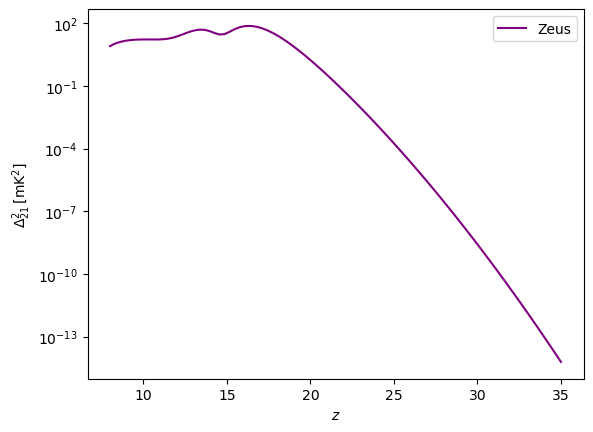

In [6]:
fig, ax = plt.subplots()  

kchoose=0.2;
_ik = min(range(len(klist)), key=lambda i: np.abs(klist[i]-kchoose))

ax.plot(zlist, powerspec21.Deltasq_T21[:,_ik],c='purple',label='Zeus')

plt.yscale('log')


plt.xlabel(r'$z$');
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');
plt.legend()


#plt.ylim([1,4e2])
#plt.xlim([12, 35])

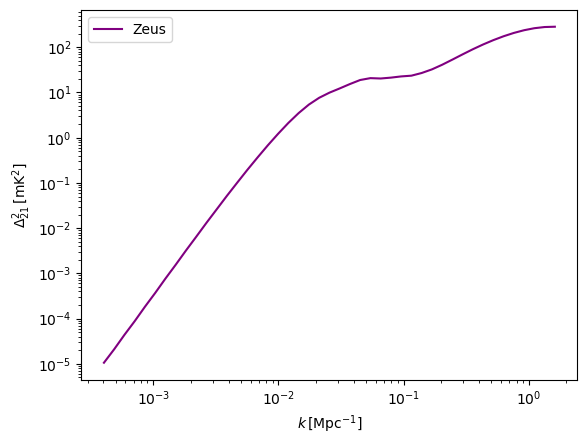

In [7]:
fig2, ax2 = plt.subplots()  

zchoose=14.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

ax2.plot(klist, powerspec21.Deltasq_T21[_iz],'k',c='purple',label='Zeus')


plt.xscale('log')
plt.yscale('log')

plt.legend()


plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');

#plt.ylim([3e-3,1e2])


(10.0, 25.0)

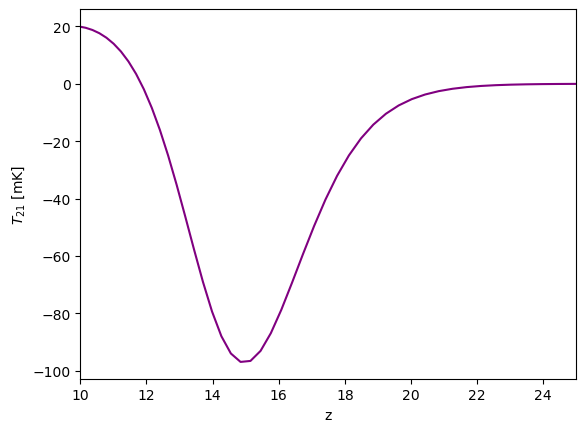

In [8]:
plt.plot(zlist,T21_coeff.T21avg, c='purple')
plt.xlabel(r'z');
plt.ylabel(r'$T_{21}$ [mK]');
plt.xlim([10, 25])


In [6]:
data = powerspec21.Deltasq_T21
noise = data*0.05

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


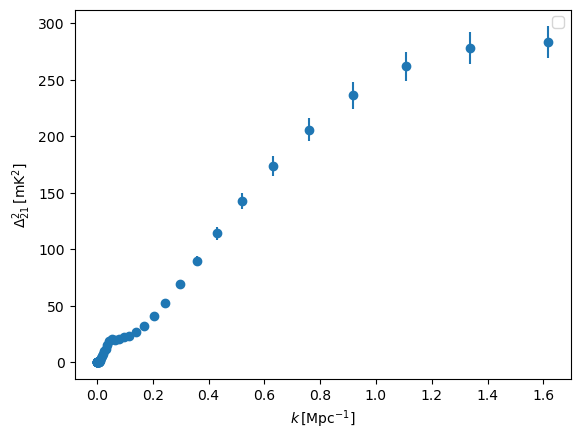

In [10]:
fig2, ax2 = plt.subplots()  

zchoose=14.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

#ax2.plot(klist, data[_iz],'k',c='purple',label='Zeus')
ax2.errorbar(klist, data[_iz], noise[_iz], fmt='o')

#plt.xscale('log')
#plt.yscale('log')

plt.legend()


plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');


In [11]:
h_peak_arr = [0.2,0.4,0.6,0.8] 

k_peak_min = 30
k_peak_max = 100

In [13]:
def log_prior(theta):
 
    if theta[0] in h_peak_arr:
        p_h = theta[0]**-1 
    else:
        p_h = 0
    if k_peak_min < theta[1] < k_peak_max:
        p_k = theta[1]**-1
    else:
        p_k     = 0
    return np.log(p_h*p_k)

def log_likelihood(theta, data, noise):
    hmfint = zeus21.HMF_interpolator(parcos, ClassyCosmo,LCDM=False, h_peak=theta[0], k_peak=theta[1])
    T21_coeff = zeus21.get_T21_coefficients(parcos, ClassyCosmo, parastro, hmfint, zmin=8) 
    powerspec21_model = zeus21.Power_Spectra(parcos, ClassCosmo, corrf, T21_coeff, RSD_MODE=1)
    #klist = powerspec21.klist_PS
    #zlist = T21_coeff.zintegral
    lh = -1/2*(np.log(2*np.pi*noise**2)+((data - powerspec21_model.Deltasq_T21)/ noise)**2)
    log_lh = np.sum(lh[:,])
    return log_lh


def log_posterior(theta, data, noise):
    
    ln_post = log_prior(theta) + log_likelihood(theta, data, noise) # sum because of log
    return ln_post 

In [14]:
theta = [0.6,55]


In [15]:
log_likelihood(theta, data, noise)

-5459587.288090826

In [11]:
%lprun -f log_likelihood log_likelihood(theta, data, noise) 

Timer unit: 1e-09 s

Total time: 10.994 s
File: /var/folders/zb/pjb0r29j7fs0t9ft3gnprvdr0000gn/T/ipykernel_87345/2828317097.py
Function: log_likelihood at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def log_likelihood(theta, data, noise):
    14         1 4154742000.0 4154742000.0     37.8      hmfint = zeus21.HMF_interpolator(parcos, ClassyCosmo,LCDM=False, h_peak=theta[0], k_peak=theta[1])
    15         1 4641527000.0 4641527000.0     42.2      T21_coeff = zeus21.get_T21_coefficients(parcos, ClassyCosmo, parastro, hmfint, zmin=8) 
    16         1 2197682000.0 2197682000.0     20.0      powerspec21_model = zeus21.Power_Spectra(parcos, ClassCosmo, corrf, T21_coeff, RSD_MODE=1)
    17                                               #klist = powerspec21.klist_PS
    18                                               #zlist = T21_coeff.zintegral
    19         1      52000.0  52000.0      0.0      lh = -1/2*(np.log

In [12]:
%lprun -f zeus21.get_T21_coefficients zeus21.get_T21_coefficients(parcos, ClassyCosmo, parastro, eth_zeus, zmin=8) 

Timer unit: 1e-09 s

In [16]:
log_posterior(theta, data, noise)

/var/folders/zb/pjb0r29j7fs0t9ft3gnprvdr0000gn/T/ipykernel_86600/2828317097.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(p_h*p_k)


-inf

In [17]:
data

array([[2.08073531e-07, 4.37371951e-07, 9.20420075e-07, ...,
        3.05607306e+01, 3.41067304e+01, 3.78538709e+01],
       [2.53405591e-07, 5.32533929e-07, 1.12085393e-06, ...,
        3.57941053e+01, 3.99369867e+01, 4.43142496e+01],
       [3.01362615e-07, 6.33137782e-07, 1.33283490e-06, ...,
        4.06514352e+01, 4.53420377e+01, 5.02971176e+01],
       ...,
       [2.26119579e-20, 4.44890433e-20, 9.31371062e-20, ...,
        9.23987305e-13, 8.88204426e-13, 7.37040488e-13],
       [3.47062359e-21, 6.81115136e-21, 1.42539228e-20, ...,
        1.56113513e-13, 1.50926528e-13, 1.26117138e-13],
       [4.96851791e-22, 9.72736567e-22, 2.03451090e-21, ...,
        2.46809755e-14, 2.40006492e-14, 2.02000073e-14]])

In [25]:
log_posterior([0.4,60], data, noise)

-4.415482976223054e+47

In [20]:
n_walkers = 100
h_peak_random = np.random.choice(h_peak_arr,n_walkers)
k_peak_random = np.random.rand(n_walkers)*(k_peak_max - k_peak_min) + k_peak_min 



In [21]:
posterior_random = np.empty(len(h_peak_random))
for i in range(len(h_peak_random)):
    theta = [h_peak_random[i], k_peak_random[i]]
    posterior_random[i] = log_posterior(theta, data, noise)

In [23]:
posterior_random

array([-4.42769115e+47, -4.43256414e+47, -5.40669116e+49, -4.23101377e+47,
       -5.15742617e+46, -2.99098493e+51, -1.33598727e+48, -4.42392468e+47,
       -2.72860659e+47, -7.58406993e+52, -4.43281351e+47, -3.13739677e+45,
       -4.09163785e+47, -1.40692687e+53, -1.12240709e+51, -4.77946092e+50,
       -1.55764559e+53, -4.43489024e+47, -4.36186002e+47, -4.43379084e+47,
       -8.69924535e+46, -4.36212058e+47, -4.43484640e+47, -4.43489744e+47,
       -4.43415558e+47, -4.03357885e+50, -2.12851270e+47, -4.43488902e+47,
       -4.43389999e+47, -1.58469440e+47, -1.50501836e+48, -4.42047659e+47,
       -6.33704363e+48, -8.80895977e+50, -3.81885645e+49, -1.24316590e+47,
       -4.43032441e+47, -4.43489743e+47, -3.51372571e+50, -4.00997928e+47,
       -4.22106344e+47, -1.01764888e+48, -2.62999590e+52, -2.55145277e+50,
       -4.43481078e+47, -4.43489744e+47, -4.43489744e+47, -3.74140351e+47,
       -4.43489732e+47, -4.43428099e+47, -4.25120186e+47, -4.43488782e+47,
       -1.04559326e+51, -

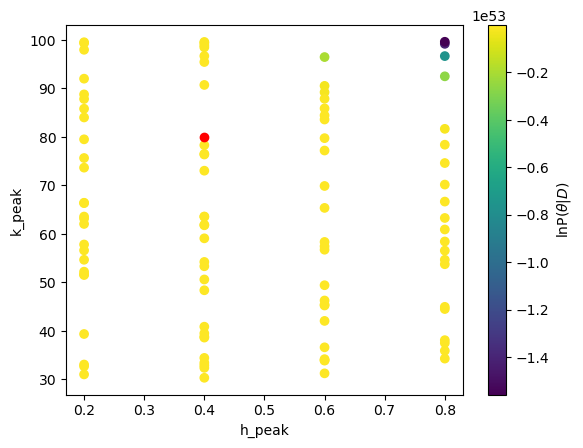

In [24]:
plt.scatter(h_peak_random, k_peak_random, c=posterior_random)
plt.xlabel('h_peak')
plt.ylabel('k_peak')
cbar = plt.colorbar()
cbar.set_label(r'lnP$(\theta|D$)')
plt.plot(0.4,80,'ro')

In [ ]:
n_walkers = 10
n_params = 2
args = [data, noise]

In [ ]:
h_peak_arr = [0.2,0.4,0.6,0.8] 

In [ ]:
h_peak_random = np.random.choice(h_peak_arr,n_walkers)
k_peak_random = np.random.rand(n_walkers)*(k_peak_max - k_peak_min) + k_peak_min 
initial_guesses = np.array([h_peak_random, k_peak_random]).T

In [ ]:
h_peak_random

array([0.6, 0.8, 0.4, 0.8, 0.2, 0.6, 0.6, 0.4, 0.8, 0.2])

In [ ]:
n_steps = 100

In [ ]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=args)